In [37]:
import numpy as np
from ISS.algorithms.mapping.fast_lidar_mapping import fast_obstacle_detection
from ISS.algorithms.planning.dp_planner import dp_planning
from ISS.algorithms.planning.hybrid_a_star.hybrid_a_star import hybrid_a_star_planner
from test_hybrid_a_star_config import config
import timeit
import pickle
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle
from scipy.spatial import cKDTree
from beamngpy import BeamNGpy, Scenario, Vehicle, set_up_simple_logging
from beamngpy.sensors import Lidar
import os
import time

USERPATH = fr'{os.getenv("LOCALAPPDATA")}/BeamNG.tech'   
beamng = BeamNGpy('localhost', 64256, user=USERPATH)
bng = beamng.open(launch=True, extensions=['util/roadData'])
scenario = Scenario('italy', 'Map Mod Test')
vehicle = Vehicle('ego_vehicle', model='vivace', license='AI', extensions=['mapPath'], partConfig='vehicles/vivace/tograc_qE_Unbreakable.pc')
scenario.add_vehicle(vehicle, pos=(-709, -1342, 141), rot_quat=(0, 0, -0.82, 0.55))
ego_pos = np.array((-709., -1342., 141.))
scenario.make(bng)
bng.settings.set_deterministic(60) # Set simulator to 60hz temporal resolution
bng.scenario.load(scenario)
bng.scenario.start()
lidar = Lidar('lidar1', bng, vehicle, requested_update_time=0.01, vertical_resolution=128, vertical_angle=54, is_using_shared_memory=True, is_visualised=True)

# Test Map Route Mod
def callPosToPosPathGeneration(veh):
    data = dict(type='PosToPosPathGeneration', goalPos=(1138.36087, 1361.30325, 141.311026))
    response = veh.connection.send(data)
    response.ack('PosToPosPathGenerationAck')

def callRequirePlan(veh):
    data = dict(type='RequirePlan')
    response = veh.connection.send(data).recv('RoutePlanData')
    return response

callPosToPosPathGeneration(vehicle)
res_data = callRequirePlan(vehicle)
while res_data['status'] == 'Pending':
    time.sleep(0.5)
    res_data = callRequirePlan(vehicle)    

route_points = np.array(res_data['route'])[:,:2]
route_kdtree = cKDTree(route_points)
inbox_index = route_kdtree.query_ball_point((ego_pos[0], ego_pos[1]), 64, p=float('inf'), return_sorted=True)



0.1866808999998284


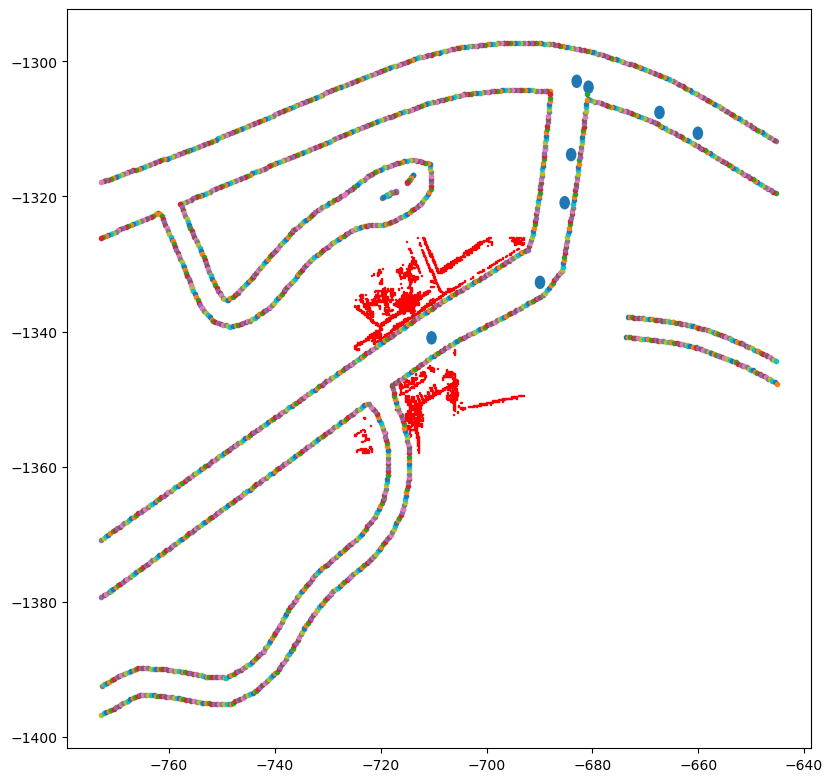

In [38]:
fig = plt.figure(1, figsize=[9.6, 9.6], dpi=100)
ax = fig.add_subplot()

for id_ in inbox_index:
    ax.add_patch(Circle((route_points[id_][0], route_points[id_][1]), 1.))

## Test Obstacle Detection
with open('../resources/data/italy_pointcloud_example.pickle', 'rb') as f:
    data = pickle.load(f)
start_time=timeit.default_timer()
obstacles = fast_obstacle_detection(data['pointCloud'].astype('float64').reshape(-1,3), ego_pos, -65536., 65536., config)
end_time=timeit.default_timer()
print(end_time-start_time)

obstacle_kdtree = cKDTree(obstacles)

for obs_ in obstacles:
    ax.add_patch(Rectangle((obs_[0] - 0.1, obs_[1] - 0.1), 0.2, 0.2, linewidth=1, edgecolor='r', facecolor='b'))

## Test Italy Map
with open('../resources/maps/italy_roadmap.pickle', 'rb') as f:
    roadmap = pickle.load(f)
road_map = roadmap['kdtree']
road_point = roadmap['points']
road_height = roadmap['heights']
map_index = road_map.query_ball_point((ego_pos[0], ego_pos[1]), 64, p=float('inf'), return_sorted=True)
for id_ in map_index:
    ax.plot(road_point[id_][0], road_point[id_][1], '.')
road_point = road_point[map_index]
road_height = road_height[map_index]
road_map = cKDTree(road_point)

0.15661249999993743


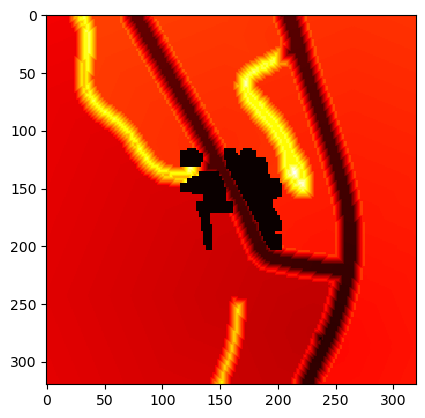

In [39]:
from test_hybrid_a_star_config import config
## Test DP Planning
start_time = timeit.default_timer()
result = dp_planning(ego_pos, route_points[inbox_index[-1]], np.array((ego_pos[0] - 64., ego_pos[0] + 64.)), np.array((ego_pos[1] - 64., ego_pos[1] + 64.)), [(obstacle_kdtree, obstacles)], [(road_map, road_point)], config)
end_time = timeit.default_timer()
print(end_time-start_time)

# result = np.flip(result, axis=0)
# result = np.flip(result, axis=1)

plt.imshow(result, cmap='hot', interpolation='nearest')
plt.show()

## Test Hybrid A Star
# start_time = timeit.default_timer()
# result = hybrid_a_star_planner(ego_pos, route_points[inbox_index[-1]], np.array((ego_pos[0] - 32., ego_pos[0] + 32.)), np.array((ego_pos[1] - 32., ego_pos[1] + 32.)), [(obstacle_kdtree, obstacles)], [(road_map, road_point)], config)
# end_time = timeit.default_timer()